In [12]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_FNN, save_MODEL, load_FNN
import diffrax
import equinox as eqx
import jax.nn as jnn
import optax

In [13]:
class Func(eqx.Module):
    out_scale: jax.Array
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.out_scale = jnp.array(1.0)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnp.sin,
            key=key,
        )

    def __call__(self, t, y, args):
        # Best practice is often to use `learnt_scalar * tanh(MLP(...))` for the
        # vector field.
        return self.out_scale * self.mlp(y)

In [14]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [15]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [16]:
alpha = 0.1
beta  = 9.80665

def f(x):
    return jnp.array([x[1], -alpha*x[1] - beta*jnp.sin(x[0])]) # Derivatives

dt = 0.01
T_final = 1.0

In [17]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=jnp.array([-jnp.pi/2, -jnp.pi]), maxval=jnp.array([jnp.pi/2, jnp.pi]))

    def f(t, x, args):
        return jnp.stack([x[1], -alpha*x[1] - beta*jnp.sin(x[0])],axis=-1)

    solver = diffrax.Tsit5()
    dt0 = dt
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.arange(0.0, T_final+dt, dt)[1:]
    # ts = jnp.linspace(0, T_final, NUM_STEPS)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [18]:
SEED = 10
WIDTH      = 20
DEPTH      = 4
# sine, cosine, relu, tanh, gelu, swish
NUM_TRAJS = 900

batch_size = 32

SEED = 1234

key = jr.PRNGKey(SEED)
key, subkey_model, loader_key, subkey_tr, subkey_tt = jr.split(key, num=5)

steps_strategy  = (500, 500)
length_strategy = (0.1, 1)
ts, ys = get_data(NUM_TRAJS, key=subkey_tr)
_, length_size, INPUT_DIM = ys.shape

model = NeuralODE(INPUT_DIM, WIDTH, DEPTH-1, key=subkey_model)

In [19]:
ys.shape

(900, 100, 2)

In [20]:
LEARNING_RATE = 3e-3
OPTIMIZER_NAME = 'adabelief'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
PRINT_EVERY = 1_00

optim = optax.adabelief(LEARNING_RATE)

In [21]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [22]:
for steps, length in zip(steps_strategy, length_strategy):
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    _ts = ts[: int(length_size * length)]
    _ys = ys[:, : int(length_size * length)]
    for step, (yi,) in zip(
        range(steps), dataloader((_ys,), batch_size, key=loader_key)
    ):
        start = time.time()
        loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        end = time.time()
        if (step % PRINT_EVERY) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 0, Loss: 0.07249632477760315, Computation time: 2.9648211002349854
Step: 100, Loss: 0.0005646484787575901, Computation time: 0.0018329620361328125
Step: 200, Loss: 9.393478103447706e-05, Computation time: 0.002254009246826172
Step: 300, Loss: 3.876694609061815e-05, Computation time: 0.0022308826446533203
Step: 400, Loss: 3.471373929642141e-05, Computation time: 0.002017974853515625
Step: 499, Loss: 2.788212259474676e-05, Computation time: 0.001827239990234375
Step: 0, Loss: 0.014704068191349506, Computation time: 2.7828853130340576
Step: 100, Loss: 0.005298898555338383, Computation time: 0.003761768341064453
Step: 200, Loss: 0.0018083509057760239, Computation time: 0.0036389827728271484
Step: 300, Loss: 0.0019916933961212635, Computation time: 0.0037071704864501953
Step: 400, Loss: 0.0006241171504370868, Computation time: 0.003507852554321289
Step: 499, Loss: 0.0006900449516251683, Computation time: 0.0035181045532226562


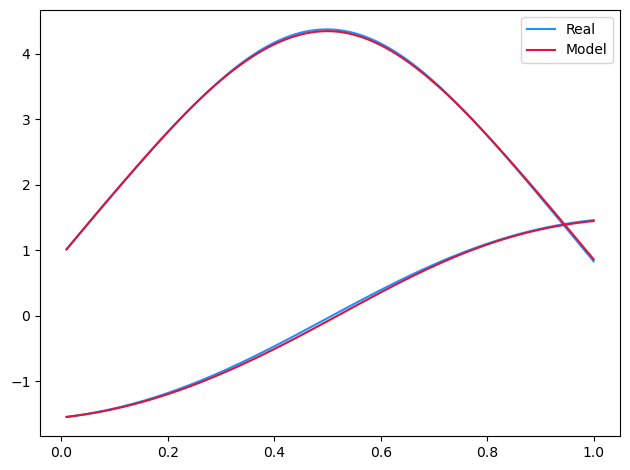

In [23]:
plt.figure()
plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, ys[0, :, 1], c="dodgerblue")
model_y = model(ts, ys[0, 0])
plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.legend()
plt.tight_layout()
# plt.savefig("neural_ode.png")
plt.show()

In [24]:
# rel_l2_error_overTraj = jnp.sqrt(jnp.sum((test_trajectories - NN_trajectories)**2,axis=0) / jnp.sum(test_trajectories**2,axis=0))

In [25]:
# rel_l2_error = jnp.sqrt(jnp.sum((test_trajectories - NN_trajectories)**2) / jnp.sum(test_trajectories**2))
# print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes[0].semilogy(tt,rel_l2_error_overTraj[:,0], label='x')
# axes[0].semilogy(tt,rel_l2_error_overTraj[:,1], label='y')
# axes[0].set_xlabel('time t')
# axes[0].set_ylabel('relative l2 error')
# axes[0].legend()
# axes[1].semilogy(log_loss)
# axes[1].semilogy(log_minloss)
# axes[1].set_xlabel('the number of iterations')
# axes[1].set_ylabel('training loss')
# plt.tight_layout()
# # plt.suptitle(title_str + '\n')
# plt.show()

In [26]:
# fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
# axe = axes.flatten()
# for i in range(len(axe)):
#     axe[i].plot(tt, NN_trajectories[i,:, 0], label='NN-x', color='magenta')
#     axe[i].plot(tt, NN_trajectories[i,:, 1], label='NN-y', color='red')
#     axe[i].plot(tt, test_trajectories[i,:, 0], label='x', color='blue', linestyle='--', linewidth=2)
#     axe[i].plot(tt, test_trajectories[i,:, 1], label='y', color='orange', linestyle='--', linewidth=2)
#     axe[i].set_xlabel('Time')
#     axe[i].set_ylabel('States')
#     axe[i].legend()
#     axe[i].set_title(f'test traj #{i}, init: ({initial_states_test[i][0]:.2f}, {initial_states_test[i][1]:.2f})')
# plt.tight_layout()
# plt.show()

In [27]:
# save_MODEL('DeepONet_HeatEqn.eqx',HYPER_MODEL,model)

In [28]:
# loaded_model = load_DeepONet('DeepONet_Diff.eqx')